In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
from torch.utils.data import DataLoader

M_Z = 91.187  # mass of Z boson (GeV)

In [2]:
dataset = pd.read_csv("./data/SM_100k.csv")
# Apply cuts
df = dataset[
    (abs(dataset["m_ll"] - M_Z) < 15)
    & (dataset["m_jj"] > 300)
    & (abs(dataset["delta_eta_jj"]) > 2.5)
]

df.count()

m_ll            69489
m_jj            69489
pt_l1           69489
pt_l2           69489
pt_j1           69489
pt_j2           69489
pt_ll           69489
eta_l1          69489
eta_l2          69489
eta_j1          69489
eta_j2          69489
delta_eta_jj    69489
delta_phi_jj    69489
dtype: int64

In [3]:
df.head()

,m_ll,m_jj,pt_l1,pt_l2,pt_j1,pt_j2,pt_ll,eta_l1,eta_l2,eta_j1,eta_j2,delta_eta_jj,delta_phi_jj
0,91.915108,817.571428,19.068266,119.288002,47.787994,174.241717,127.214313,0.601289,-0.827524,-3.112653,1.247709,-4.360361,-3.293960
1,91.554900,2404.014354,48.863130,87.367985,107.964679,177.910879,106.054348,-0.455842,0.039917,3.143773,-2.557357,5.701129,-3.725031
2,91.987715,662.842055,26.142133,128.186262,99.888379,107.257538,127.337882,2.250787,1.749627,1.845531,-1.855586,3.701117,-1.819143
3,91.241031,1242.649786,88.205101,27.274699,213.088461,244.515221,72.516153,0.011753,0.331417,1.069279,-2.251527,3.320807,2.854300
5,91.631566,1377.158854,198.064595,26.920807,180.215152,101.485660,207.975866,-0.466679,-0.903119,0.651112,-3.990533,4.641645,-1.557752


In [4]:
# select variables
selection = [
    "m_ll",
    "m_jj",
    "pt_l1",
    "pt_l2",
    "pt_j1",
    "pt_j2",
    "pt_ll",
    "eta_l1",
    "eta_l2",
    "eta_j1",
    "eta_j2",
    "delta_eta_jj",
    "delta_phi_jj",
]
df = df[selection]
for vars in ["m_ll", "m_jj", "pt_l1", "pt_l2", "pt_j1", "pt_j2", "pt_ll"]:
    df[vars] = df[vars].apply(np.log10)

In [5]:
X_train, X_test = train_test_split(df, test_size=0.2)
X_train, X_valid = train_test_split(df, test_size=0.2)

In [6]:
# MinMax scaling
t = MinMaxScaler()
t.fit(X_train)
X_train = t.transform(X_train)
X_test = t.transform(X_test)
X_valid = t.transform(X_valid)

In [7]:
# create train and test dataloaders
batch_size = 50
train_loader = DataLoader(dataset=X_train, batch_size=batch_size)
test_loader = DataLoader(dataset=X_test, batch_size=batch_size)
valid_loader = DataLoader(dataset=X_valid, batch_size=batch_size)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [8]:
class VAE(nn.Module):

    def __init__(
        self,
        input_dim=13,
        intermediate_dim=28,
        latent_dim=6,
        relu_slope=1e-1,
    ):
        super(VAE, self).__init__()

        # encoder
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, intermediate_dim),
            nn.LeakyReLU(relu_slope),
            nn.Linear(intermediate_dim, intermediate_dim),
            nn.LeakyReLU(relu_slope),
            nn.Linear(intermediate_dim, intermediate_dim),
            nn.LeakyReLU(relu_slope),
            nn.Linear(intermediate_dim, 2 * latent_dim),
            nn.LeakyReLU(relu_slope),
        )

        # latent mu and variance
        self.mu_layer = nn.Linear(2 * latent_dim, latent_dim)
        self.logvar_layer = nn.Linear(2 * latent_dim, latent_dim)

        # decoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 2 * latent_dim),
            nn.LeakyReLU(relu_slope),
            nn.Linear(2 * latent_dim, intermediate_dim),
            nn.LeakyReLU(relu_slope),
            nn.Linear(intermediate_dim, intermediate_dim),
            nn.LeakyReLU(relu_slope),
            nn.Linear(intermediate_dim, intermediate_dim),
            nn.LeakyReLU(relu_slope),
            nn.Linear(intermediate_dim, input_dim),
            nn.Sigmoid(),
        )

    def encode(self, x):
        x = self.encoder(x)
        mu, logvar = self.mu_layer(x), self.logvar_layer(x)
        return mu, logvar

    def reparameterization(self, mu, std):
        epsilon = torch.randn_like(std).to(device)
        z = mu + std * epsilon
        return z

    def decode(self, x):
        return self.decoder(x)

    def forward(self, x):
        mu, logvar = self.encode(x)
        std = (0.5 * logvar).exp()
        z = self.reparameterization(mu, std)
        x_hat = self.decode(z)
        return x_hat, mu, logvar

In [9]:
model = VAE().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)


def loss_function(x, x_hat, mu, logvar, beta=1e-6):
    reproduction_loss = nn.functional.binary_cross_entropy(x_hat, x, reduction="sum")
    # reproduction_loss = nn.functional.mse_loss(x_hat, x)
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    return reproduction_loss, beta * KLD

In [10]:
def epoch(model):
    repro_epoch = 0
    KLD_epoch = 0
    for idx, x in enumerate(train_loader):
        x = x.float().to(device)
        optimizer.zero_grad()

        x_hat, mean, log_var = model.forward(x)
        repro, KLD = loss_function(x, x_hat, mean, log_var)
        loss = repro + KLD

        repro_epoch += repro.item()
        KLD_epoch += KLD.item()

        loss.backward()
        optimizer.step()

    return repro_epoch, KLD_epoch

In [11]:
def eval(model):
    model.eval()
    repro_eval = 0
    KLD_eval = 0
    for idx, x in enumerate(valid_loader):
        x = x.float().to(device)
        x = torch.clamp(x, min=0, max=1)
        x_hat, mean, log_var = model.forward(x)
        repro, KLD = loss_function(x, x_hat, mean, log_var)

        repro_eval += repro.item()
        KLD_eval += KLD.item()
    return repro_eval, KLD_eval

In [12]:
epochs = 10
for e in range(epochs):
    print(f"=== EPOCH {e} ===")
    train_repro, train_KLD = epoch(model)
    valid_repro, valid_KLD = eval(model)
    print(
        f"training loss : {train_repro/len(train_loader.dataset):.2e}, {train_KLD/len(train_loader.dataset):.2e}, eval loss : {valid_repro/len(valid_loader.dataset):.2e}, {valid_KLD/len(valid_loader.dataset):.2e}"
    )

=== EPOCH 0 ===
training loss : 8.19e+00, 6.50e-05, eval loss : 8.05e+00, 6.68e-05
=== EPOCH 1 ===
training loss : 7.98e+00, 6.84e-05, eval loss : 7.93e+00, 6.72e-05
=== EPOCH 2 ===
training loss : 7.92e+00, 6.54e-05, eval loss : 7.90e+00, 6.36e-05
=== EPOCH 3 ===
training loss : 7.90e+00, 6.31e-05, eval loss : 7.91e+00, 6.15e-05
=== EPOCH 4 ===
training loss : 7.86e+00, 6.84e-05, eval loss : 7.85e+00, 7.08e-05
=== EPOCH 5 ===
training loss : 7.84e+00, 6.34e-05, eval loss : 7.84e+00, 6.38e-05
=== EPOCH 6 ===
training loss : 7.83e+00, 6.41e-05, eval loss : 7.83e+00, 6.78e-05
=== EPOCH 7 ===
training loss : 7.83e+00, 6.40e-05, eval loss : 7.82e+00, 6.08e-05
=== EPOCH 8 ===
training loss : 7.81e+00, 6.53e-05, eval loss : 7.79e+00, 5.94e-05
=== EPOCH 9 ===
training loss : 7.79e+00, 5.78e-05, eval loss : 7.78e+00, 5.75e-05


In [13]:
model.eval()
T_test = torch.from_numpy(X_test).float().to(device)
X_hat, mean, log_var = model.forward(T_test)
X_hat = X_hat.detach().cpu()
print(T_test.size(), X_hat.size())

torch.Size([13898, 13]) torch.Size([13898, 13])


Text(0.5, 1.0, 'Test set (grey) vs reconstruction (red)')

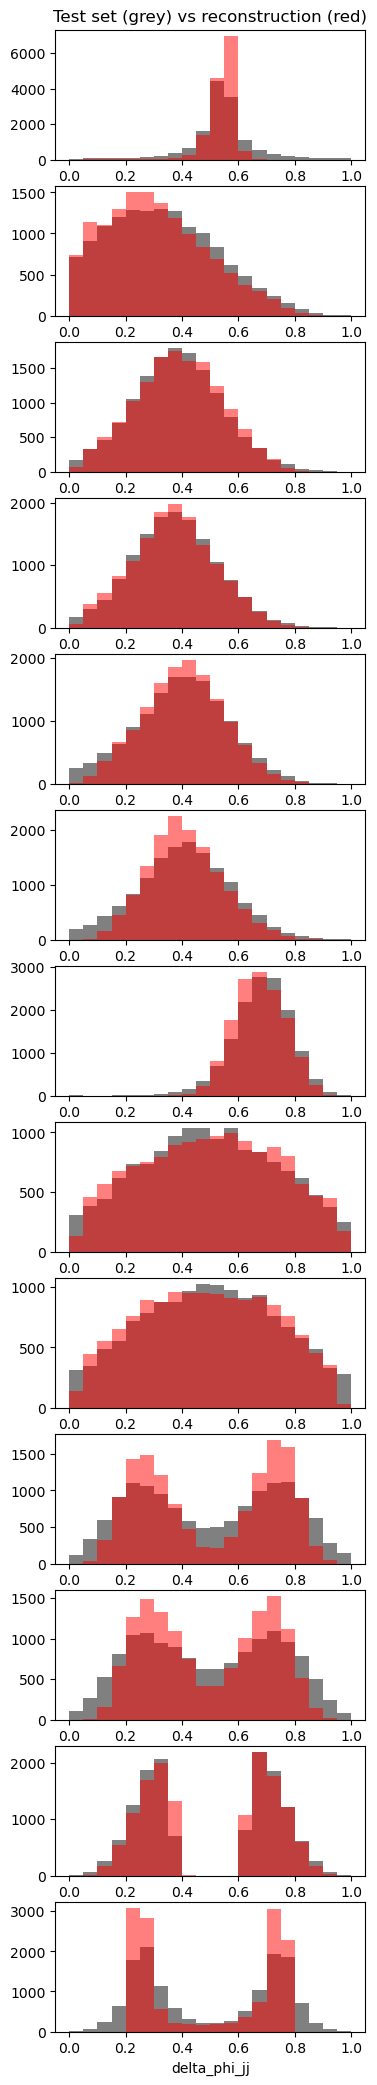

In [14]:
n_bins = 20
n_features = len(selection)
fig, ax = plt.subplots(n_features, 1, figsize=(4, 2 * n_features))
for i in range(n_features):
    ax[i].hist(X_test[:, i], bins=n_bins, range=(0, 1), color="grey")
    ax[i].hist(X_hat[:, i], bins=n_bins, range=(0, 1), color="red", alpha=0.5)
    ax[i].set_xlabel(selection[i])
ax[0].set_title("Test set (grey) vs reconstruction (red)")

# BSM data

In [15]:
dataset = pd.read_csv("./data/SM_10k.csv")

# Apply cuts
df = dataset[
    (abs(dataset["m_ll"] - M_Z) < 15)
    & (dataset["m_jj"] > 300)
    & (abs(dataset["delta_eta_jj"]) > 2.5)
]

df = df[selection]
for vars in ["m_ll", "m_jj", "pt_l1", "pt_l2", "pt_j1", "pt_j2", "pt_ll"]:
    df[vars] = df[vars].apply(np.log10)

X_sm = t.transform(df)

model.eval()
T_sm = torch.from_numpy(X_sm).float().to(device)
X_sm_hat, mean, log_var = model.forward(T_sm)
X_sm_hat = X_sm_hat.detach().cpu()
print(T_sm.size(), X_sm_hat.size())

torch.Size([6983, 13]) torch.Size([6983, 13])


In [25]:
o1 = pd.read_csv("./data/cHDD_1_10k.csv")
o2 = pd.read_csv("./data/cHDD_2_10k.csv")

dataset = pd.concat([o1, o2], axis=0)

# Apply cuts
df = dataset[
    (abs(dataset["m_ll"] - M_Z) < 15)
    & (dataset["m_jj"] > 300)
    & (abs(dataset["delta_eta_jj"]) > 2.5)
]

df = df[selection]
for vars in ["m_ll", "m_jj", "pt_l1", "pt_l2", "pt_j1", "pt_j2", "pt_ll"]:
    df[vars] = df[vars].apply(np.log10)

X_bsm = t.transform(df)

model.eval()
T_bsm = torch.from_numpy(X_bsm).float().to(device)
X_bsm_hat, mean, log_var = model.forward(T_bsm)
X_bsm_hat = X_bsm_hat.detach().cpu()
print(T_bsm.size(), X_bsm_hat.size())

torch.Size([12704, 13]) torch.Size([12704, 13])


Text(0.5, 1.0, 'BSM events')

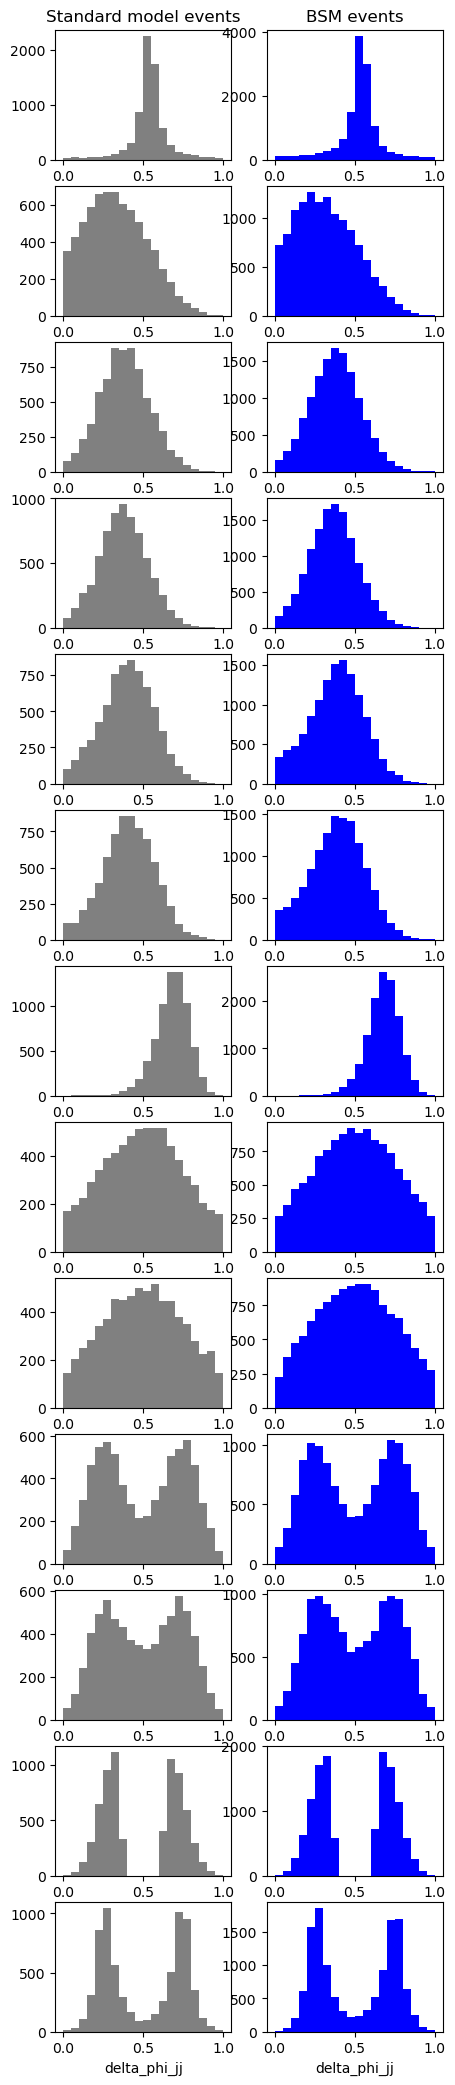

In [26]:
n_bins = 20
n_features = len(selection)
fig, ax = plt.subplots(n_features, 2, figsize=(5, 2 * n_features))
for i in range(n_features):
    ax[i, 0].hist(X_sm[:, i], bins=n_bins, range=(0, 1), color="grey")
    ax[i, 1].hist(X_bsm[:, i], bins=n_bins, range=(0, 1), color="blue")
    ax[i, 0].set_xlabel(selection[i])
    ax[i, 1].set_xlabel(selection[i])
ax[0, 0].set_title("Standard model events")
ax[0, 1].set_title("BSM events")

Text(0.5, 1.0, 'SM (grey) vs reconstruction (red)')

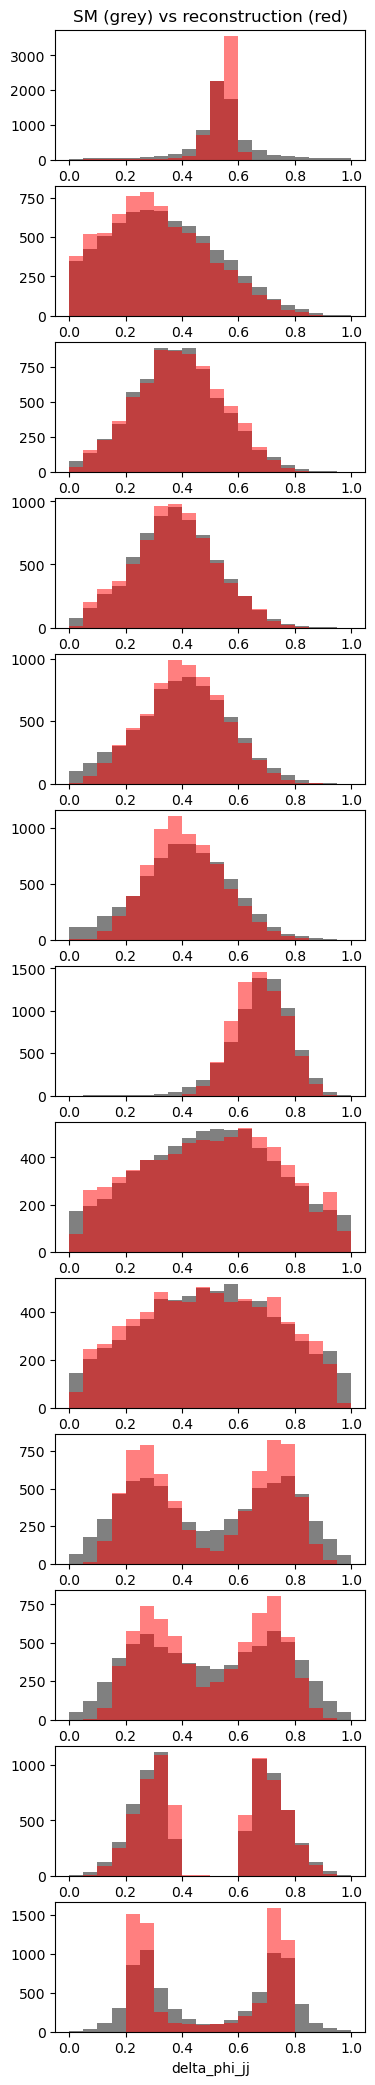

In [27]:
n_bins = 20
n_features = len(selection)
fig, ax = plt.subplots(n_features, 1, figsize=(4, 2 * n_features))
for i in range(n_features):
    ax[i].hist(X_sm[:, i], bins=n_bins, range=(0, 1), color="grey")
    ax[i].hist(X_sm_hat[:, i], bins=n_bins, range=(0, 1), color="red", alpha=0.5)
    ax[i].set_xlabel(selection[i])

ax[0].set_title("SM (grey) vs reconstruction (red)")

Text(0.5, 1.0, 'BSM (grey) vs reconstruction (red)')

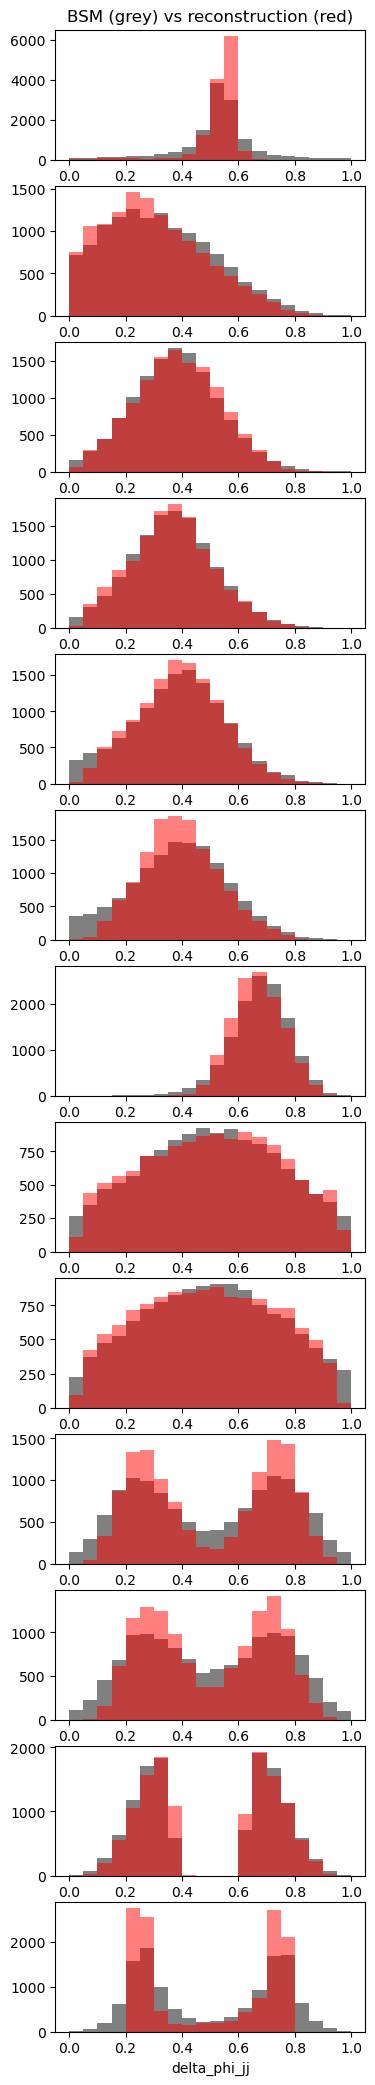

In [28]:
n_bins = 20
n_features = len(selection)
fig, ax = plt.subplots(n_features, 1, figsize=(4, 2 * n_features))
for i in range(n_features):
    ax[i].hist(X_bsm[:, i], bins=n_bins, range=(0, 1), color="grey")
    ax[i].hist(X_bsm_hat[:, i], bins=n_bins, range=(0, 1), color="red", alpha=0.5)
    ax[i].set_xlabel(selection[i])
ax[0].set_title("BSM (grey) vs reconstruction (red)")

In [29]:
def compute_errors(X, X_hat, loss_fn="bce"):
    n_events = X.shape[0]
    error = np.zeros(n_events)
    if loss_fn == "bce":
        for i in range(n_events):
            error[i] = nn.functional.binary_cross_entropy(
                torch.clamp(X[i, :], 0, 1),
                torch.clamp(X_hat[i, :], 0, 1),
                reduction="sum",
            )

    elif loss_fn == "mse":
        for i in range(n_events):
            error[i] = nn.functional.mse_loss(X[i, :], X_hat[i, :])
    return error


def ROC_curve(err_SM, err_BSM):
    K = np.linspace(0, max(np.max(err_SM), np.max(err_BSM)), 1000)
    FP = [np.sum(err_SM > k) / err_SM.size for k in K]
    TP = [np.sum(err_BSM > k) / err_BSM.size for k in K]
    AUC = np.trapz(np.sort(TP), np.sort(FP))

    return TP, FP, AUC

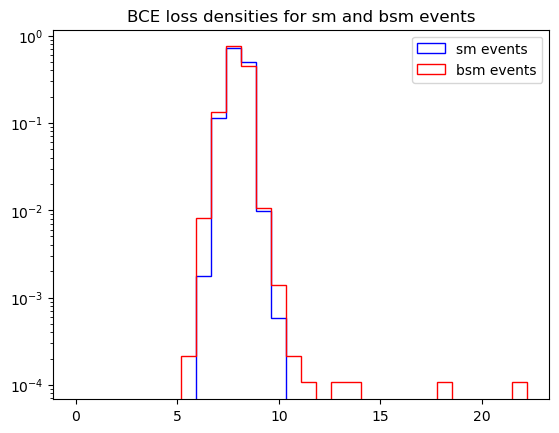

In [30]:
err_sm_bce = compute_errors(torch.from_numpy(X_sm).float(), X_sm_hat.float())
err_bsm_bce = compute_errors(torch.from_numpy(X_bsm).float(), X_bsm_hat.float())
plt.hist(
    err_sm_bce,
    bins=30,
    range=(0, np.max(err_bsm_bce)),
    density=True,
    color="blue",
    histtype="step",
    label="sm events",
)
plt.hist(
    err_bsm_bce,
    bins=30,
    range=(0, np.max(err_bsm_bce)),
    density=True,
    color="red",
    histtype="step",
    label="bsm events",
)
plt.yscale("log")
plt.title("BCE loss densities for sm and bsm events")
plt.legend()

AUC : 0.4726453735159623


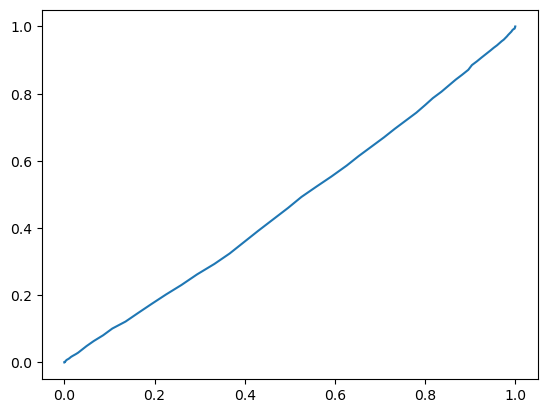

In [31]:
TP, FP, AUC = ROC_curve(err_sm_bce, err_bsm_bce)
print(f"AUC : {AUC}")
plt.plot(FP, TP)

Text(0.5, 1.0, 'MSE loss densities for sm and bsm events')

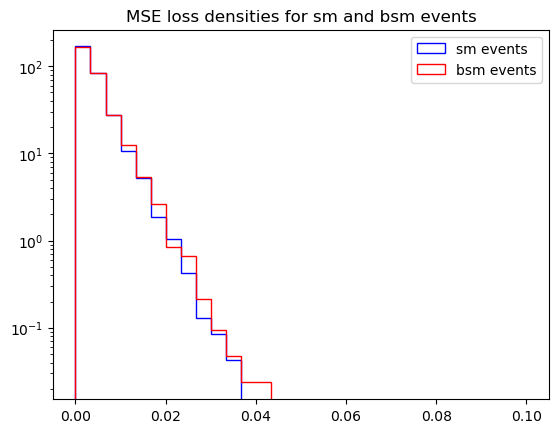

In [32]:
err_sm_mse = compute_errors(
    torch.from_numpy(X_sm).float(), X_sm_hat.float(), loss_fn="mse"
)
err_bsm_mse = compute_errors(
    torch.from_numpy(X_bsm).float(), X_bsm_hat.float(), loss_fn="mse"
)
plt.hist(
    err_sm_mse,
    bins=30,
    range=(0, 0.1),
    density=True,
    color="blue",
    histtype="step",
    label="sm events",
)
plt.hist(
    err_bsm_mse,
    bins=30,
    range=(0, 0.1),
    density=True,
    color="red",
    histtype="step",
    label="bsm events",
)
plt.yscale("log")
plt.legend()
plt.title("MSE loss densities for sm and bsm events")

AUC : 0.5060589864518039


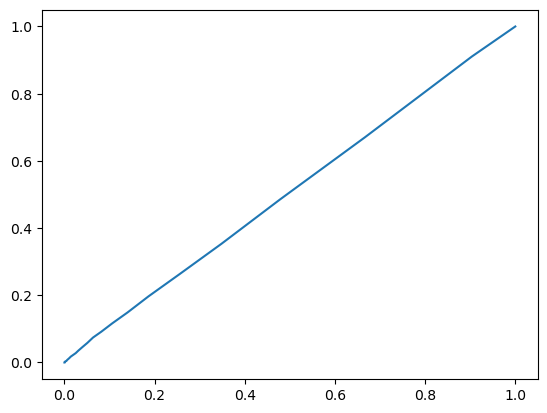

In [33]:
K = np.linspace(0, 0.1, 100)
FP = [np.sum(err_sm_mse > k) / err_sm_bce.size for k in K]
TP = [np.sum(err_bsm_mse > k) / err_bsm_bce.size for k in K]
AUC = np.trapz(np.sort(TP), np.sort(FP))
print(f"AUC : {AUC}")
plt.plot(FP, TP)

In [63]:
latent_dim = np.linspace(1, 13, 13)
AUC_bce = []
AUC_mse = []
epochs = 10
for l in latent_dim:
    print(l)
    model = VAE(latent_dim=int(l)).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)
    for e in range(epochs):
        train_repro, train_KLD = epoch(model)

    model.eval()
    X_bsm_hat, mean, log_var = model.forward(T_bsm)
    X_bsm_hat = X_bsm_hat.detach().cpu()
    X_sm_hat, mean, log_var = model.forward(T_sm)
    X_sm_hat = X_sm_hat.detach().cpu()

    err_sm_bce = compute_errors(torch.from_numpy(X_sm).float(), X_sm_hat.float())
    err_bsm_bce = compute_errors(torch.from_numpy(X_bsm).float(), X_bsm_hat.float())
    TP, FP, AUC = ROC_curve(err_sm_bce, err_bsm_bce)
    AUC_bce.append(AUC)
    err_sm_bce = compute_errors(
        torch.from_numpy(X_sm).float(), X_sm_hat.float(), loss_fn="mse"
    )
    err_bsm_bce = compute_errors(
        torch.from_numpy(X_bsm).float(), X_bsm_hat.float(), loss_fn="mse"
    )
    TP, FP, AUC = ROC_curve(err_sm_bce, err_bsm_bce)
    AUC_mse.append(AUC)

1.0
2.0
3.0
4.0
5.0
6.0
7.0
8.0
9.0
10.0
11.0
12.0
13.0


In [64]:
print(AUC_bce)
print(AUC_mse)

[0.6704010281512127, 0.6563099709407437, 0.6573200735040391, 0.5931266747453291, 0.5459241553961072, 0.5613807849472456, 0.587976800613112, 0.5352492849498961, 0.5887705716129099, 0.5490531971973379, 0.5782207711185351, 0.5073200890155455, 0.5853628959448619]
[0.675886416170403, 0.6879822552681156, 0.6471726145133937, 0.5861847292832734, 0.5909611605229027, 0.5779884559591437, 0.559839008636146, 0.5597668126892918, 0.6195172708553589, 0.5753979938982051, 0.6400775030402216, 0.5124935136612064, 0.612165302321758]


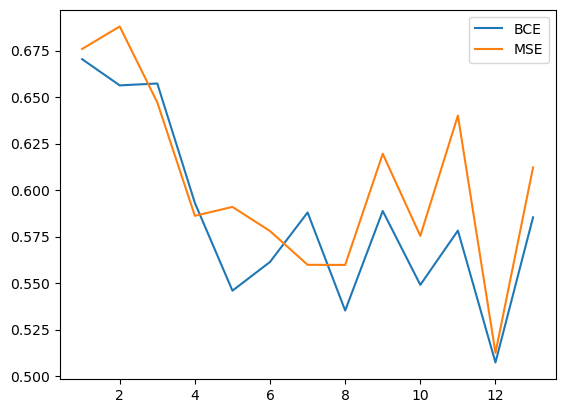

In [65]:
plt.plot(latent_dim, AUC_bce, label="BCE")
plt.plot(latent_dim, AUC_mse, label="MSE")
plt.legend()

In [69]:
l = 8
AUC_bce = []
AUC_mse = []
epochs = np.linspace(1, 10, 10)
for e in epochs:
    print(e)
    model = VAE(latent_dim=int(l)).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)

    for _ in range(int(e)):
        train_repro, train_KLD = epoch(model)

    model.eval()
    X_bsm_hat, mean, log_var = model.forward(T_bsm)
    X_bsm_hat = X_bsm_hat.detach().cpu()
    X_sm_hat, mean, log_var = model.forward(T_sm)
    X_sm_hat = X_sm_hat.detach().cpu()

    err_sm_bce = compute_errors(torch.from_numpy(X_sm).float(), X_sm_hat.float())
    err_bsm_bce = compute_errors(torch.from_numpy(X_bsm).float(), X_bsm_hat.float())
    TP, FP, AUC = ROC_curve(err_sm_bce, err_bsm_bce)
    AUC_bce.append(AUC)
    err_sm_bce = compute_errors(
        torch.from_numpy(X_sm).float(), X_sm_hat.float(), loss_fn="mse"
    )
    err_bsm_bce = compute_errors(
        torch.from_numpy(X_bsm).float(), X_bsm_hat.float(), loss_fn="mse"
    )
    TP, FP, AUC = ROC_curve(err_sm_bce, err_bsm_bce)
    AUC_mse.append(AUC)

1.0
2.0
3.0
4.0
5.0
6.0
7.0
8.0
9.0
10.0


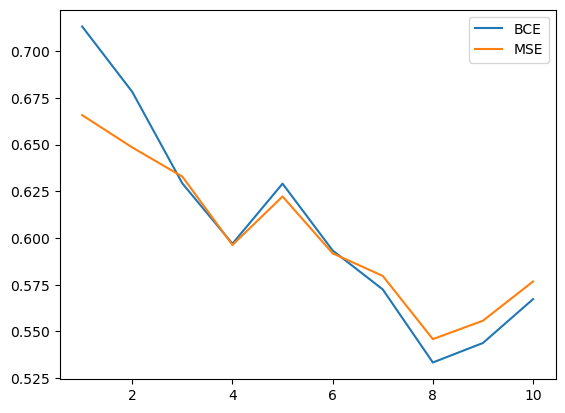

In [ ]:
plt.plot(epochs, AUC_bce, label="BCE")
plt.plot(epochs, AUC_mse, label="MSE")
plt.legend()